In [144]:
import matplotlib
import matplotlib.pyplot as plt
from matplotlib.colors import BoundaryNorm
from matplotlib.ticker import MaxNLocator

import cartopy.feature as feature
import cartopy.crs as ccrs
from cartopy.io import shapereader

import iris
import iris.analysis.cartography
import iris.quickplot as qplt
import iris.plot as iplt
#from ctd import plot_section
from oceans.colormaps import cm
from oceans.colormaps import cm as ocncm
from mpl_toolkits.basemap import cm as bmcm
from matplotlib.colors import LinearSegmentedColormap as LSC

from iris.coords import DimCoord

import numpy as np

from netCDF4 import Dataset
#gridline stuff
import matplotlib.ticker as mticker
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER

from scipy.stats.stats import pearsonr   

import scipy.ndimage as ndimage


import xray
import dask

import numpy as np
import itertools
from math import sqrt,ceil


%matplotlib inline

In [145]:
#datadir="/reserved1/p/peltier/guido/diagdata/cesmi6gafv1vdp"
datadir="/scratch/guido/diagdata"

In [146]:
ts = xray.open_dataset(datadir+'/cesmi6gafv1vdp_1700-4599_atmwgtavg_TS_anom.nc')

In [8]:
ts.coords

/home/guido/anaconda2/lib/python2.7/site-packages/xarray/conventions.py:401: RuntimeWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using dummy netCDF4.datetime objects instead, reason: dates out of range
  calendar=self.calendar)


Coordinates:
  * lon      (lon) float64 0.0 1.25 2.5 3.75 5.0 6.25 7.5 8.75 10.0 11.25 ...
  * lat      (lat) float64 -90.0 -89.06 -88.12 -87.17 -86.23 -85.29 -84.35 ...
  * time     (time) datetime64[ns] 1705-07-17T17:17:35.000004 ...

In [9]:
# redue Load data
filepath1 = datadir+'/cesmi6gafv1vdp_1700-4599_ocnwgtavg_SST_anom.nc'
osstcube = iris.load_cube(filepath1)


/home/guido/anaconda2/lib/python2.7/site-packages/iris/fileformats/cf.py:1139: UserWarning: NetCDF default loading behaviour currently does not expose variables which define reference surfaces for dimensionless vertical coordinates as independent Cubes. This behaviour is deprecated in favour of automatic promotion to Cubes. To switch to the new behaviour, set iris.FUTURE.netcdf_promote to True.
  warnings.warn(msg)


In [10]:
print osstcube[:,0,:,:]

Potential Temperature                            (time: 290; -- : 384; -- : 320)
     Dimension coordinates:
          time                                        x         -         -
     Auxiliary coordinates:
          latitude                                    -         x         x
          longitude                                   -         x         x
     Scalar coordinates:
          depth from surface to midpoint of layer: 500.0 centimeters
     Attributes:
          CDI: Climate Data Interface version 1.5.4 (http://code.zmaw.de/projects/cdi...
          CDO: Climate Data Operators version 1.5.4 (http://code.zmaw.de/projects/cdo...
          Conventions: CF-1.0; http://www.cgd.ucar.edu/cms/eaton/netcdf/CF-current.htm
          contents: Diagnostic and Prognostic Variables
          grid_loc: 3111
          history: Tue May 31 14:47:03 2016: ncatted -O -a calendar,global,d,, cesmi6gafv1vdp_1700-4599_ocnwgtavg_SST_anom.nc
Tue...
          nco_openmp_thread_number: 2
       

In [11]:
filepath2 = datadir+'/cesmi6gafv1vdp_1700-4599_ocnwgtavg_T150m_anom.nc'
ot150cube = iris.load_cube(filepath2)


/home/guido/anaconda2/lib/python2.7/site-packages/iris/fileformats/_pyke_rules/compiled_krb/fc_rules_cf_fc.py:1228: UserWarning: Skipping global attribute u'cell_methods': 'cell_methods' is not a permitted attribute
  warnings.warn(msg.format(attr_name, str(e)))
/home/guido/anaconda2/lib/python2.7/site-packages/iris/fileformats/_pyke_rules/compiled_krb/fc_rules_cf_fc.py:1228: UserWarning: Skipping global attribute u'calendar': 'calendar' is not a permitted attribute
  warnings.warn(msg.format(attr_name, str(e)))


In [12]:
# Choose plot projections
projections = {}
projections['Mollweide'] = ccrs.Mollweide()
projections['PlateCarree'] = ccrs.PlateCarree()
projections['NorthPolarStereo'] = ccrs.NorthPolarStereo()
projections['Orthographic'] = ccrs.Orthographic(central_longitude=-90,central_latitude=45)
pcarree = projections['PlateCarree']


In [13]:
nxdim=360
nydim=180

In [14]:
newosstcube, extent = iris.analysis.cartography.project(osstcube[:,0,:,:], pcarree,nx=nxdim, ny=nydim)
newot150cube, extent = iris.analysis.cartography.project(ot150cube[:,0,:,:], pcarree,nx=nxdim, ny=nydim)


/home/guido/anaconda2/lib/python2.7/site-packages/iris/analysis/cartography.py:548: UserWarning: Coordinate system of latitude and longitude coordinates is not specified. Assuming WGS84 Geodetic.
  warnings.warn('Coordinate system of latitude and longitude '


In [15]:
print newosstcube

Potential Temperature                            (time: 290; projection_y_coordinate: 180; projection_x_coordinate: 360)
     Dimension coordinates:
          time                                        x                             -                             -
          projection_y_coordinate                     -                             x                             -
          projection_x_coordinate                     -                             -                             x
     Auxiliary coordinates:
          latitude                                    -                             x                             x
          longitude                                   -                             x                             x
     Scalar coordinates:
          depth from surface to midpoint of layer: 500.0 centimeters
     Attributes:
          CDI: Climate Data Interface version 1.5.4 (http://code.zmaw.de/projects/cdi...
          CDO: Climate Data Operators versi

In [16]:
ts.time.values
tstime=np.array(range(1700,4600,10))
tstime.shape


(290,)

In [17]:
itime = DimCoord(tstime, standard_name='time', units='years')
latitude = DimCoord(ts.lat.values, standard_name='latitude', units='degrees')
longitude = DimCoord(ts.lon.values, standard_name='longitude', units='degrees')
#tscorcube = iris.cube.Cube((edmltscorr[:,:,0].T, np.float64),dim_coords_and_dims=[(latitude, 0), (longitude, 1)])

In [18]:
tscube = iris.cube.Cube(ts.TS.values,dim_coords_and_dims=[(itime, 0), (latitude, 1), (longitude, 2)])

In [19]:
print tscube

unknown / (unknown)                 (time: 290; latitude: 192; longitude: 288)
     Dimension coordinates:
          time                           x              -               -
          latitude                       -              x               -
          longitude                      -              -               x


In [20]:
newtscube, extent = iris.analysis.cartography.project(tscube, pcarree,nx=nxdim, ny=nydim)


In [21]:
print newtscube

unknown / (unknown)                 (time: 290; projection_y_coordinate: 180; projection_x_coordinate: 360)
     Dimension coordinates:
          time                           x                             -                             -
          projection_y_coordinate        -                             x                             -
          projection_x_coordinate        -                             -                             x
     Auxiliary coordinates:
          latitude                       -                             x                             x
          longitude                      -                             x                             x


In [22]:
ts.lon

<xarray.DataArray 'lon' (lon: 288)>
array([   0.  ,    1.25,    2.5 ,    3.75,    5.  ,    6.25,    7.5 ,
          8.75,   10.  ,   11.25,   12.5 ,   13.75,   15.  ,   16.25,
         17.5 ,   18.75,   20.  ,   21.25,   22.5 ,   23.75,   25.  ,
         26.25,   27.5 ,   28.75,   30.  ,   31.25,   32.5 ,   33.75,
         35.  ,   36.25,   37.5 ,   38.75,   40.  ,   41.25,   42.5 ,
         43.75,   45.  ,   46.25,   47.5 ,   48.75,   50.  ,   51.25,
         52.5 ,   53.75,   55.  ,   56.25,   57.5 ,   58.75,   60.  ,
         61.25,   62.5 ,   63.75,   65.  ,   66.25,   67.5 ,   68.75,
         70.  ,   71.25,   72.5 ,   73.75,   75.  ,   76.25,   77.5 ,
         78.75,   80.  ,   81.25,   82.5 ,   83.75,   85.  ,   86.25,
         87.5 ,   88.75,   90.  ,   91.25,   92.5 ,   93.75,   95.  ,
         96.25,   97.5 ,   98.75,  100.  ,  101.25,  102.5 ,  103.75,
        105.  ,  106.25,  107.5 ,  108.75,  110.  ,  111.25,  112.5 ,
        113.75,  115.  ,  116.25,  117.5 ,  118.75,  1

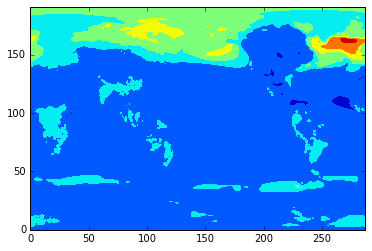

In [23]:
plt.contourf(ts.TS[0,...])

In [24]:
#EDML coordinates
# 75S 0W

# WDC
#79S 112W
print 360-112

248


In [25]:
ts.lon.values

array([   0.  ,    1.25,    2.5 ,    3.75,    5.  ,    6.25,    7.5 ,
          8.75,   10.  ,   11.25,   12.5 ,   13.75,   15.  ,   16.25,
         17.5 ,   18.75,   20.  ,   21.25,   22.5 ,   23.75,   25.  ,
         26.25,   27.5 ,   28.75,   30.  ,   31.25,   32.5 ,   33.75,
         35.  ,   36.25,   37.5 ,   38.75,   40.  ,   41.25,   42.5 ,
         43.75,   45.  ,   46.25,   47.5 ,   48.75,   50.  ,   51.25,
         52.5 ,   53.75,   55.  ,   56.25,   57.5 ,   58.75,   60.  ,
         61.25,   62.5 ,   63.75,   65.  ,   66.25,   67.5 ,   68.75,
         70.  ,   71.25,   72.5 ,   73.75,   75.  ,   76.25,   77.5 ,
         78.75,   80.  ,   81.25,   82.5 ,   83.75,   85.  ,   86.25,
         87.5 ,   88.75,   90.  ,   91.25,   92.5 ,   93.75,   95.  ,
         96.25,   97.5 ,   98.75,  100.  ,  101.25,  102.5 ,  103.75,
        105.  ,  106.25,  107.5 ,  108.75,  110.  ,  111.25,  112.5 ,
        113.75,  115.  ,  116.25,  117.5 ,  118.75,  120.  ,  121.25,
        122.5 ,  123

In [140]:
#EDML
print ts.lon[0].values
#WDC
print ts.lon[198].values
#NGRIP
print ts.lon[254].values
#EDML
print ts.lat[16].values
#WDC
print ts.lat[11].values
#NGRIP
print ts.lat[175].values

0.0
247.5
317.5
-74.9214659686
-79.6335078534
74.9214659686


In [135]:
360-42

318

In [27]:
tsdata=ts.TS.values

In [28]:
print tsdata.shape

(290, 192, 288)


In [29]:
print ts.dims.items()

[(u'lat', 192), (u'lon', 288), (u'time', 290)]


In [30]:
edmltscorr=np.array([ [ pearsonr(tsdata[:,i,j],tsdata[:,16,0]) for i in range(0,192) ] for j in range(0,288) ])

In [31]:
edmltscorr.shape

(288, 192, 2)

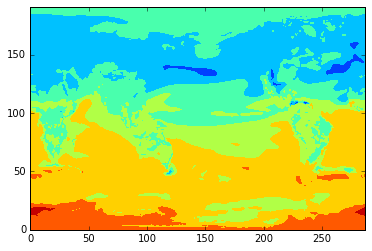

In [32]:
plt.contourf(edmltscorr[:,:,0].T)

In [33]:
latitude = DimCoord(ts.lat.values, standard_name='latitude', units='degrees')
longitude = DimCoord(ts.lon.values, standard_name='longitude', units='degrees')
#tscorcube = iris.cube.Cube((edmltscorr[:,:,0].T, np.float64),dim_coords_and_dims=[(latitude, 0), (longitude, 1)])

In [34]:
edmltscorr[:,:,0].T.shape

(192, 288)

In [35]:
# EDML TS correlation
tscorcube = iris.cube.Cube(edmltscorr[:,:,0].T,dim_coords_and_dims=[(latitude, 0), (longitude, 1)])

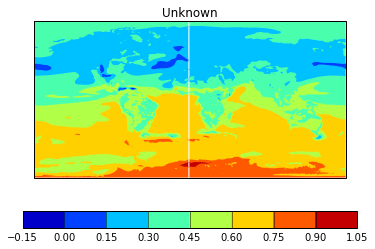

In [36]:
qplt.contourf(tscorcube)

In [37]:
wdctscorr=np.array([ [ pearsonr(tsdata[:,i,j],tsdata[:,11,198]) for i in range(0,192) ] for j in range(0,288) ])

In [38]:
wdctscorcube = iris.cube.Cube(wdctscorr[:,:,0].T,dim_coords_and_dims=[(latitude, 0), (longitude, 1)])

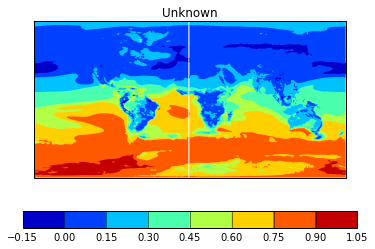

In [39]:
qplt.contourf(wdctscorcube)

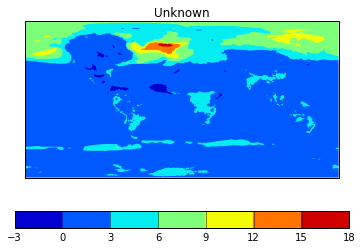

In [40]:
### Do correlations between atm TS and ocean SST
qplt.contourf(newtscube[0,:,:])


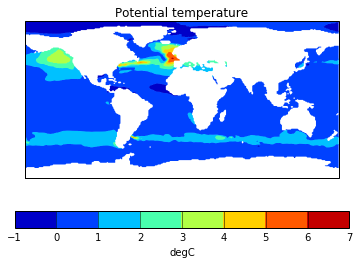

In [41]:
### Do correlations between atm TS and ocean SST
qplt.contourf(newosstcube[0,:,:])

In [42]:
# edml location on 360x720 grid
xcoord=newtscube.coord('projection_x_coordinate')
ycoord=newtscube.coord('projection_y_coordinate')
print xcoord[180]
print ycoord[14]
print xcoord[67]
print ycoord[10]

DimCoord(array([ 0.5]), standard_name='projection_x_coordinate', units=Unit('1'))
DimCoord(array([-75.5]), standard_name='projection_y_coordinate', units=Unit('1'))
DimCoord(array([-112.5]), standard_name='projection_x_coordinate', units=Unit('1'))
DimCoord(array([-79.5]), standard_name='projection_y_coordinate', units=Unit('1'))


In [43]:
print newtscube.data.shape

(290, 180, 360)


In [44]:
print nxdim
print nydim

360
180


In [45]:
edmltscorr=np.array([ [ pearsonr(newtscube[:,i,j].data,newtscube[:,14,180].data) for i in range(0,nydim) ] for j in range(0,nxdim) ])

In [46]:
edmlosstcorr=np.array([ [ pearsonr(newosstcube[:,i,j].data,newtscube[:,14,180].data) for i in range(0,nydim) ] for j in range(0,nxdim) ])

In [47]:
edmlot150corr=np.array([ [ pearsonr(newot150cube[:,i,j].data,newtscube[:,14,180].data) for i in range(0,nydim) ] for j in range(0,nxdim) ])

In [48]:
#WDC
wdctscorr=np.array([ [ pearsonr(newtscube[:,i,j].data,newtscube[:,10,67].data) for i in range(0,nydim) ] for j in range(0,nxdim) ])
wdcosstcorr=np.array([ [ pearsonr(newosstcube[:,i,j].data,newtscube[:,10,67].data) for i in range(0,nydim) ] for j in range(0,nxdim) ])
wdcot150corr=np.array([ [ pearsonr(newot150cube[:,i,j].data,newtscube[:,10,67].data) for i in range(0,nydim) ] for j in range(0,nxdim) ])

In [49]:
edmltscorr.shape

(360, 180, 2)

In [50]:
lat = DimCoord(ycoord.points, standard_name='latitude', units='degrees')
lon = DimCoord(xcoord.points, standard_name='longitude', units='degrees')


In [51]:
newedmltscorcube = iris.cube.Cube(edmltscorr[:,:,0].T,dim_coords_and_dims=[(lat, 0), (lon, 1)])
newedmlosstcorcube = iris.cube.Cube(edmlosstcorr[:,:,0].T,dim_coords_and_dims=[(lat, 0), (lon, 1)])
newedmlot150corcube = iris.cube.Cube(edmlot150corr[:,:,0].T,dim_coords_and_dims=[(lat, 0), (lon, 1)])

In [52]:
newwdctscorcube = iris.cube.Cube(wdctscorr[:,:,0].T,dim_coords_and_dims=[(lat, 0), (lon, 1)])
newwdcosstcorcube = iris.cube.Cube(wdcosstcorr[:,:,0].T,dim_coords_and_dims=[(lat, 0), (lon, 1)])
newwdcot150corcube = iris.cube.Cube(wdcot150corr[:,:,0].T,dim_coords_and_dims=[(lat, 0), (lon, 1)])

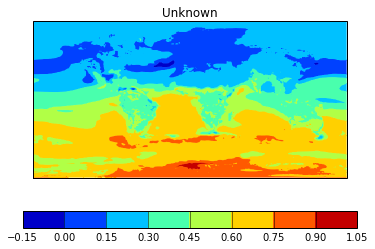

In [54]:


qplt.contourf(newedmltscorcube)


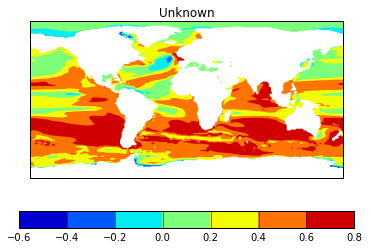

In [55]:
qplt.contourf(newedmlot150corcube)

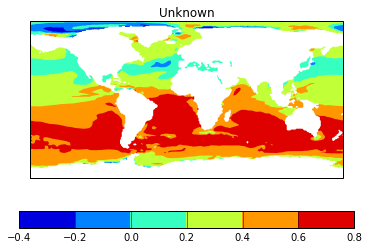

In [56]:
qplt.contourf(newedmlosstcorcube)

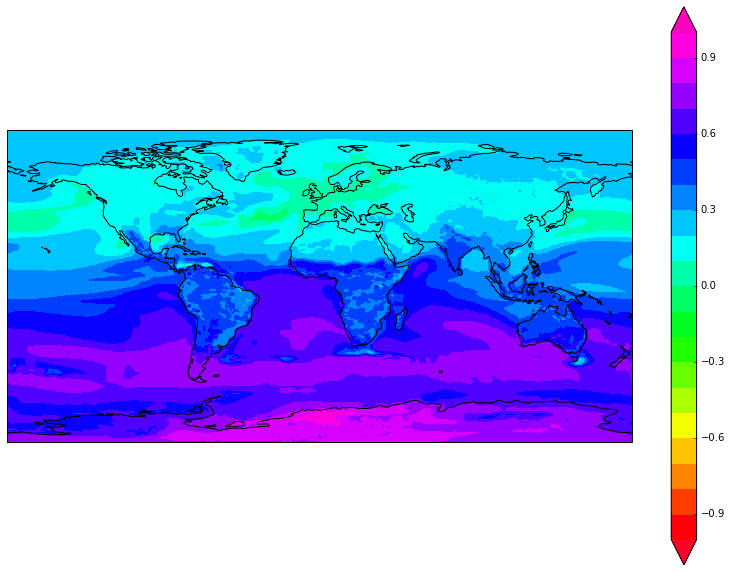

In [57]:
fig = plt.figure(facecolor='white', figsize = (14,10))

#ax=plt.subplot(111)
ax = plt.axes(projection=ccrs.PlateCarree())
colormap = matplotlib.cm.gist_rainbow

contour_levels = np.linspace(-1, 1, 21)

projlons=newtscube.coord('projection_x_coordinate')
projlats=newtscube.coord('projection_y_coordinate')
cntsplot=ax.contourf(projlons.points,projlats.points,newedmltscorcube.data,contour_levels,
                     transform=ccrs.PlateCarree(),cmap=colormap,extend='both')

# Add coastlines to the map created by contourf. (Natural earth website not reachable ???)
#plt.gca().coastlines()

#ax.add_feature(feature.GSHHSFeature('coarse', edgecolor='black'))

ax.add_geometries(list(shapereader.Reader("ne_110m_coastline.shp").geometries()), ccrs.PlateCarree(),facecolor='none') 
plt.colorbar(cntsplot)

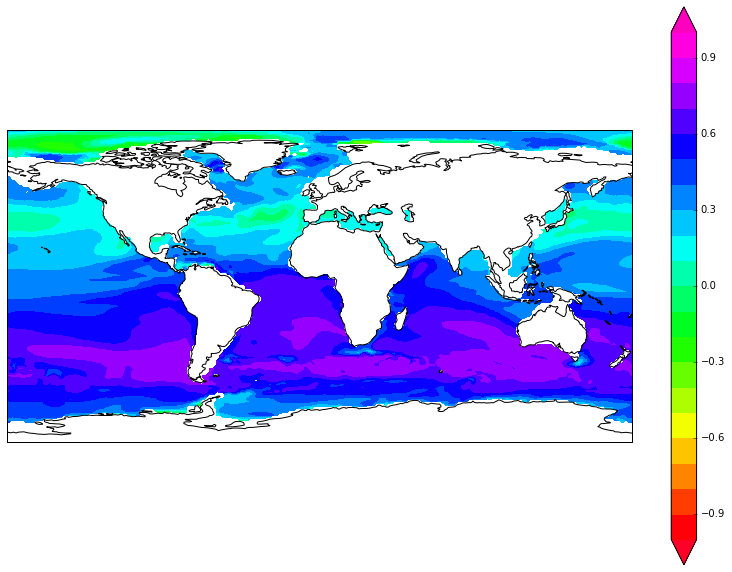

In [58]:
fig = plt.figure(facecolor='white', figsize = (14,10))

#ax=plt.subplot(111)
ax = plt.axes(projection=ccrs.PlateCarree())
colormap = matplotlib.cm.gist_rainbow

contour_levels = np.linspace(-1, 1, 21)

projlons=newosstcube.coord('projection_x_coordinate')
projlats=newosstcube.coord('projection_y_coordinate')
cntsplot=ax.contourf(projlons.points,projlats.points,newedmlosstcorcube.data,contour_levels,
                     transform=ccrs.PlateCarree(),cmap=colormap,extend='both')

# Add coastlines to the map created by contourf. (Natural earth website not reachable ???)
#plt.gca().coastlines()

#ax.add_feature(feature.GSHHSFeature('coarse', edgecolor='black'))

ax.add_geometries(list(shapereader.Reader("ne_110m_coastline.shp").geometries()), ccrs.PlateCarree(),facecolor='none') 
plt.colorbar(cntsplot)

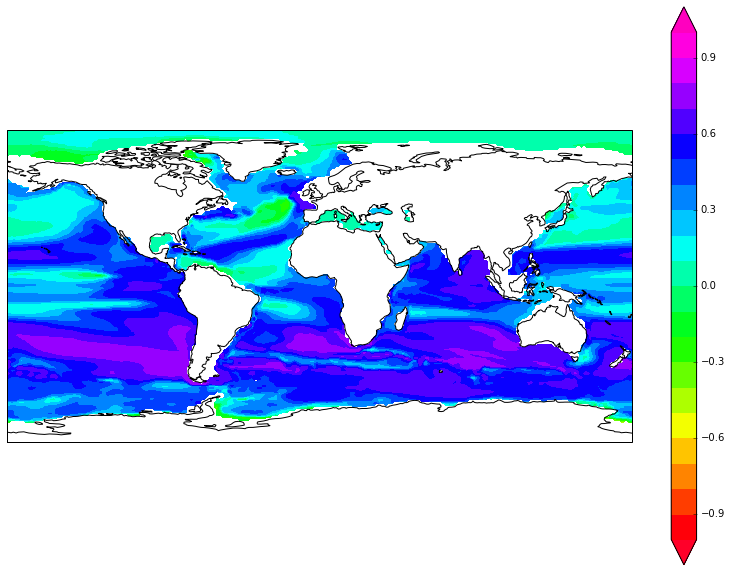

In [59]:
fig = plt.figure(facecolor='white', figsize = (14,10))

#ax=plt.subplot(111)
ax = plt.axes(projection=ccrs.PlateCarree())
colormap = matplotlib.cm.gist_rainbow

contour_levels = np.linspace(-1, 1, 21)

projlons=newosstcube.coord('projection_x_coordinate')
projlats=newosstcube.coord('projection_y_coordinate')
cntsplot=ax.contourf(projlons.points,projlats.points,newedmlot150corcube.data,contour_levels,
                     transform=ccrs.PlateCarree(),cmap=colormap,extend='both')

# Add coastlines to the map created by contourf. (Natural earth website not reachable ???)
#plt.gca().coastlines()

#ax.add_feature(feature.GSHHSFeature('coarse', edgecolor='black'))

ax.add_geometries(list(shapereader.Reader("ne_110m_coastline.shp").geometries()), ccrs.PlateCarree(),facecolor='none') 
plt.colorbar(cntsplot)

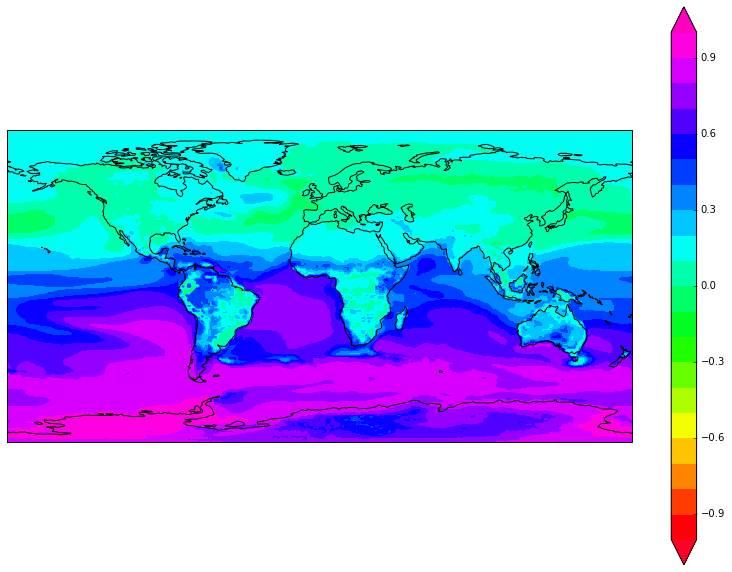

In [60]:
fig = plt.figure(facecolor='white', figsize = (14,10))

#ax=plt.subplot(111)
ax = plt.axes(projection=ccrs.PlateCarree())
colormap = matplotlib.cm.gist_rainbow

contour_levels = np.linspace(-1, 1, 21)

projlons=newtscube.coord('projection_x_coordinate')
projlats=newtscube.coord('projection_y_coordinate')
cntsplot=ax.contourf(projlons.points,projlats.points,newwdctscorcube.data,contour_levels,
                     transform=ccrs.PlateCarree(),cmap=colormap,extend='both')

# Add coastlines to the map created by contourf. (Natural earth website not reachable ???)
#plt.gca().coastlines()

#ax.add_feature(feature.GSHHSFeature('coarse', edgecolor='black'))

ax.add_geometries(list(shapereader.Reader("ne_110m_coastline.shp").geometries()), ccrs.PlateCarree(),facecolor='none') 
plt.colorbar(cntsplot)

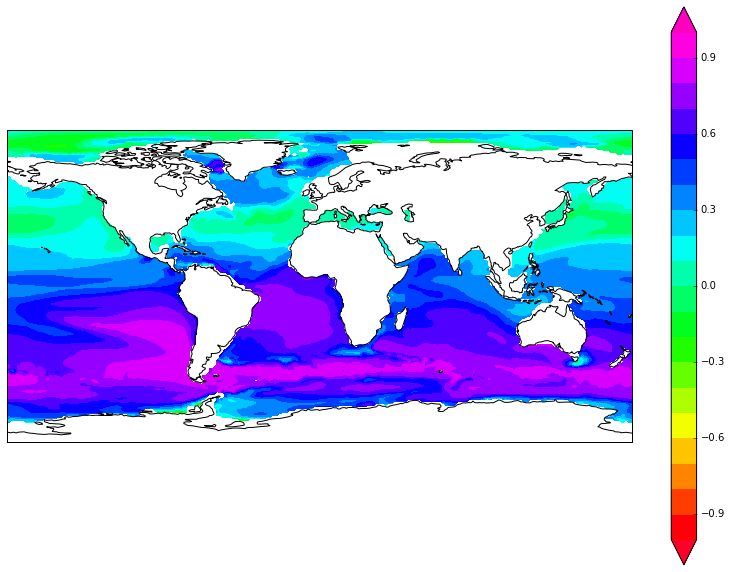

In [61]:
fig = plt.figure(facecolor='white', figsize = (14,10))

#ax=plt.subplot(111)
ax = plt.axes(projection=ccrs.PlateCarree())
colormap = matplotlib.cm.gist_rainbow

contour_levels = np.linspace(-1, 1, 21)

projlons=newosstcube.coord('projection_x_coordinate')
projlats=newosstcube.coord('projection_y_coordinate')
cntsplot=ax.contourf(projlons.points,projlats.points,newwdcosstcorcube.data,contour_levels,
                     transform=ccrs.PlateCarree(),cmap=colormap,extend='both')

# Add coastlines to the map created by contourf. (Natural earth website not reachable ???)
#plt.gca().coastlines()

#ax.add_feature(feature.GSHHSFeature('coarse', edgecolor='black'))

ax.add_geometries(list(shapereader.Reader("ne_110m_coastline.shp").geometries()), ccrs.PlateCarree(),facecolor='none') 
plt.colorbar(cntsplot)

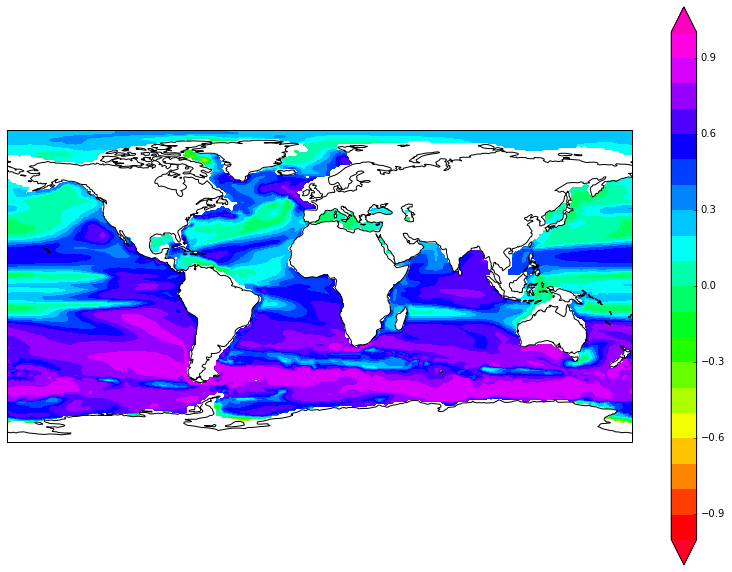

In [62]:
fig = plt.figure(facecolor='white', figsize = (14,10))

#ax=plt.subplot(111)
ax = plt.axes(projection=ccrs.PlateCarree())
colormap = matplotlib.cm.gist_rainbow

contour_levels = np.linspace(-1, 1, 21)

projlons=newosstcube.coord('projection_x_coordinate')
projlats=newosstcube.coord('projection_y_coordinate')
cntsplot=ax.contourf(projlons.points,projlats.points,newwdcot150corcube.data,contour_levels,
                     transform=ccrs.PlateCarree(),cmap=colormap,extend='both')

# Add coastlines to the map created by contourf. (Natural earth website not reachable ???)
#plt.gca().coastlines()

#ax.add_feature(feature.GSHHSFeature('coarse', edgecolor='black'))

ax.add_geometries(list(shapereader.Reader("ne_110m_coastline.shp").geometries()), ccrs.PlateCarree(),facecolor='none') 
plt.colorbar(cntsplot)

In [89]:
print lon.points[180]
print lat.points[16]
print lon.points[68]
print lat.points[11]

0.5
-73.5
-111.5
-78.5


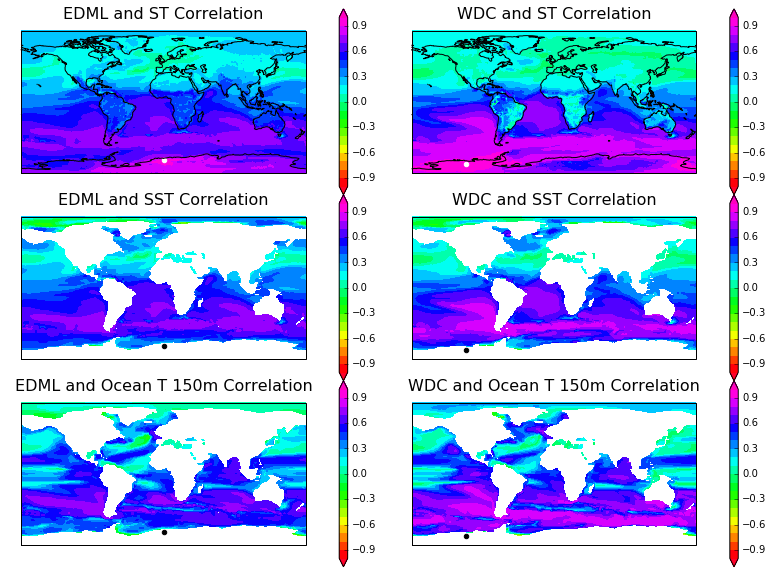

In [109]:
fig = plt.figure(facecolor='white', figsize = (14,10))

colormap = matplotlib.cm.gist_rainbow
contour_levels = np.linspace(-1, 1, 21)
projlons=newtscube.coord('projection_x_coordinate')
projlats=newtscube.coord('projection_y_coordinate')

######################
ax1=plt.subplot(321,projection=ccrs.PlateCarree())
cntsplot1=ax1.contourf(projlons.points,projlats.points,newedmltscorcube.data,contour_levels,
                     transform=ccrs.PlateCarree(),cmap=colormap,extend='both')
ax1.scatter(lon.points[180],lat.points[16],color='white')
ax1.add_geometries(list(shapereader.Reader("ne_110m_coastline.shp").geometries()), ccrs.PlateCarree(),facecolor='none') 
ax1.set_title('EDML and ST Correlation',size=16)
plt.colorbar(cntsplot1)
######################
ax2=plt.subplot(322,projection=ccrs.PlateCarree())
cntsplot2=ax2.contourf(projlons.points,projlats.points,newwdctscorcube.data,contour_levels,
                     transform=ccrs.PlateCarree(),cmap=colormap,extend='both')
ax2.scatter(lon.points[68],lat.points[11],color='white')
ax2.add_geometries(list(shapereader.Reader("ne_110m_coastline.shp").geometries()), ccrs.PlateCarree(),facecolor='none') 
ax2.set_title('WDC and ST Correlation',size=16)
plt.colorbar(cntsplot2)

######################
ax1=plt.subplot(323,projection=ccrs.PlateCarree())
cntsplot1=ax1.contourf(projlons.points,projlats.points,newedmlosstcorcube.data,contour_levels,
                     transform=ccrs.PlateCarree(),cmap=colormap,extend='both')
ax1.scatter(lon.points[180],lat.points[16],color='k')
#ax1.add_geometries(list(shapereader.Reader("ne_110m_coastline.shp").geometries()), ccrs.PlateCarree(),facecolor='none') 
ax1.set_title('EDML and SST Correlation',size=16)
plt.colorbar(cntsplot1)
######################
ax2=plt.subplot(324,projection=ccrs.PlateCarree())
cntsplot2=ax2.contourf(projlons.points,projlats.points,newwdcosstcorcube.data,contour_levels,
                     transform=ccrs.PlateCarree(),cmap=colormap,extend='both')
ax2.scatter(lon.points[68],lat.points[11],color='k')
#ax2.add_geometries(list(shapereader.Reader("ne_110m_coastline.shp").geometries()), ccrs.PlateCarree(),facecolor='none') 
ax2.set_title('WDC and SST Correlation',size=16)
plt.colorbar(cntsplot2)

######################
ax1=plt.subplot(325,projection=ccrs.PlateCarree())
cntsplot1=ax1.contourf(projlons.points,projlats.points,newedmlot150corcube.data,contour_levels,
                     transform=ccrs.PlateCarree(),cmap=colormap,extend='both')
ax1.scatter(lon.points[180],lat.points[16],color='k')
#ax1.add_geometries(list(shapereader.Reader("ne_110m_coastline.shp").geometries()), ccrs.PlateCarree(),facecolor='none') 
ax1.set_title('EDML and Ocean T 150m Correlation',size=16)
plt.colorbar(cntsplot1)
######################
ax2=plt.subplot(326,projection=ccrs.PlateCarree())
cntsplot2=ax2.contourf(projlons.points,projlats.points,newwdcot150corcube.data,contour_levels,
                     transform=ccrs.PlateCarree(),cmap=colormap,extend='both')
ax2.scatter(lon.points[68],lat.points[11],color='k')
#ax2.add_geometries(list(shapereader.Reader("ne_110m_coastline.shp").geometries()), ccrs.PlateCarree(),facecolor='none') 
ax2.set_title('WDC and Ocean T 150m Correlation',size=16)
plt.colorbar(cntsplot2)

plt.subplots_adjust(hspace=0,wspace=0)

# Saveplot
icepaperdir="/home/guido/Dropbox/plots/VP_2016_teleconnection/"
saveplot=False
if saveplot:
    figname='figx_correlations1'
    plt.savefig(icepaperdir+figname+".png", dpi=300, bbox_inches='tight')
    plt.savefig(icepaperdir+figname+".pdf",bbox_inches='tight')
    #plt.savefig(icepaperdir+figname+".tiff", dpi=300,bbox_inches='tight')
    #Image.open(icepaperdir+figname+".png").save(icepaperdir+figname+".jpg",'JPEG')


In [116]:
def setaxesfsize(axl,fontsize):
    ticklabelbot = axl.get_xticklabels()
    ticklabelleft = axl.get_yticklabels()
    for labelx in ticklabelbot:
        labelx.set_fontsize(fontsize)
    for labely in ticklabelleft:
            labely.set_fontsize(fontsize)


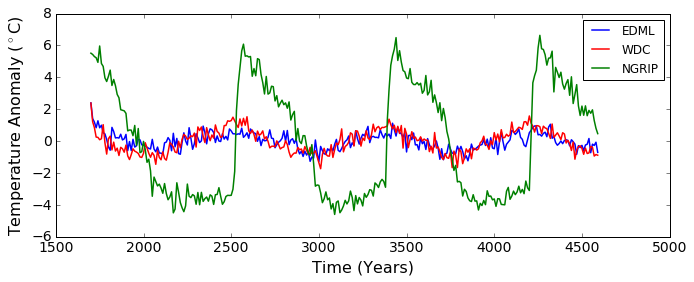

In [143]:
# plot EDML and WDC timeseries
fig = plt.figure(facecolor='white', figsize = (11,4))

lw=1.5
######################
ax1=plt.subplot(111)

ax1.plot(tstime,tsdata[:,16,0],color='b',label='EDML',linewidth=lw)
ax1.plot(tstime,tsdata[:,11,198],color='r',label='WDC',linewidth=lw)
ax1.plot(tstime,tsdata[:,175,254],color='g',label='NGRIP',linewidth=lw)
setaxesfsize(ax1,14)
ax1.set_ylabel('Temperature Anomaly ($^\circ$C)',size=16)
ax1.set_xlabel('Time (Years)',size=16)
ax1.legend()

# Saveplot
icepaperdir="/home/guido/Dropbox/plots/VP_2016_teleconnection/"
saveplot=False
if saveplot:
    figname='figx_model_EDML_WDC_NGRIP_TS'
    plt.savefig(icepaperdir+figname+".png", dpi=300, bbox_inches='tight')
    plt.savefig(icepaperdir+figname+".pdf",bbox_inches='tight')
    #plt.savefig(icepaperdir+figname+".tiff", dpi=300,bbox_inches='tight')
    #Image.open(icepaperdir+figname+".png").save(icepaperdir+figname+".jpg",'JPEG')
